# SetUp

In [1]:
# LOAD LIBRARIES
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(future))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(presto))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(tictoc))

suppressPackageStartupMessages(library(enrichR))
suppressPackageStartupMessages(library(org.Hs.eg.db))
suppressPackageStartupMessages(library(AnnotationDbi))

suppressPackageStartupMessages(library(SingleR))

suppressPackageStartupMessages(library(GPTCelltype))
suppressPackageStartupMessages(library(openai))

In [2]:
total_time <- function(seconds) {
    d <- seconds %/% (86400)
    h <- (seconds %% 86400) %/% 3600
    m <- (seconds %% 3600) %/% 60
    s <- seconds %% 60
    
    cat(sprintf("Total Time: %f Days, %f Hours, %f Minutes and %f Seconds\n", d, h, m, s))
}

In [5]:
timepoints = c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month")
housekeeping_genes = c("ACTB", "DLG4")
genes_of_interest = c("SRCIN1", "KIAA1217", "CIT")
path_to_data = "/sharedFolder/Data/"
dir_save = "Results_september/"
res_list = c(1, 0.5, 0.2, 0.1)#seq(0.1, 1, by = 0.1)
dim_list = c(1:20)
top_n_genes = 50

# Genes of interest

In [6]:
file_name <- timepoints[1]

In [11]:
cluster_markers <- read.csv(paste0(dir_save, file_name, "/", file_name, "_cluster_markers.csv"))
head(cluster_markers)

,X,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,DCT,0,1.780295,0.383,0.161,0,0,DCT
2,AMBN,0,1.767947,0.431,0.175,0,0,AMBN
3,HEY1,0,1.708512,0.464,0.202,0,0,HEY1
4,LINC01551,0,1.623801,0.767,0.311,0,0,LINC01551
5,OLFM3,0,1.543925,0.396,0.189,0,0,OLFM3
6,SFRP1,0,1.514941,0.968,0.510,0,0,SFRP1


In [12]:
de_genes <- cluster_markers %>% filter(gene %in% housekeeping_genes)
de_genes

X,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
ACTB,1.010527e-264,0.5787216,0.995,0.990,2.390504e-260,2,ACTB
ACTB1,1.097050e-134,0.4359230,0.979,0.991,2.595182e-130,4,ACTB
ACTB2,1.876753e-237,0.5989018,0.996,0.990,4.439648e-233,5,ACTB
ACTB3,3.362324e-97,0.6680805,0.998,0.990,7.953914e-93,13,ACTB
ACTB4,7.775647e-17,0.4518253,1.000,0.990,1.839407e-12,15,ACTB
ACTB5,2.285339e-04,0.3712490,0.988,0.990,1.000000e+00,16,ACTB


In [54]:
de.genes <- function(
    file_name,
    goi,
    hk
) {
    cluster_markers <- read.csv(paste0(dir_save, file_name, "/", file_name, "_cluster_markers.csv"))

    de_list <- list(
        Genes_of_interest = cluster_markers %>% filter(gene %in% goi),
        Housekeeping_genes = cluster_markers %>% filter(gene %in% hk)
    )

    for (nm in names(de_list)) {
        if (nrow(de_list[[nm]]) > 0) de_list[[nm]]$type <- as.character(nm)
    }

    de_genes <- bind_rows(de_list)

    return(de_genes)
}

In [57]:
de_genes <- de.genes(
    file_name = timepoints[2],
    goi = genes_of_interest,
    hk = housekeeping_genes
)
de_genes

X,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
KIAA1217,0.000000e+00,1.5384309,0.269,0.063,0.000000e+00,3,KIAA1217,Genes_of_interest
CIT,0.000000e+00,2.6738312,0.341,0.048,0.000000e+00,5,CIT,Genes_of_interest
SRCIN1,4.037321e-240,2.1950285,0.256,0.069,1.027700e-235,13,SRCIN1,Genes_of_interest
DLG4,0.000000e+00,2.1206821,0.273,0.078,0.000000e+00,2,DLG4,Housekeeping_genes
ACTB,0.000000e+00,0.3648709,0.997,0.994,0.000000e+00,2,ACTB,Housekeeping_genes
ACTB1,1.093337e-235,0.3347923,0.995,0.995,2.783090e-231,4,ACTB,Housekeeping_genes
ACTB2,3.338006e-76,0.6202881,1.000,0.995,8.496894e-72,18,ACTB,Housekeeping_genes
ACTB3,6.358112e-73,0.7321708,1.000,0.995,1.618457e-68,19,ACTB,Housekeeping_genes
ACTB4,3.151907e-06,0.3073137,0.990,0.995,8.023178e-02,20,ACTB,Housekeeping_genes


In [58]:
# save
file_name = timepoints[2]
dir_results <- paste0(dir_save, file_name)     
if (!dir.exists(dir_results)) {dir.create(dir_results)} 
write.csv(de_genes, file = paste0(dir_results, "/", file_name,"_de_genes",".csv"))

In [56]:
for (file_name in timepoints) {
    de_genes <- de.genes(
        file_name = file_name,
        goi = genes_of_interest,
        hk = housekeeping_genes
    )
    print(file_name)
    print(de_genes)

    dir_results <- paste0(dir_save, file_name)     
    if (!dir.exists(dir_results)) {dir.create(dir_results)} 
    
    write.csv(de_genes, file = paste0(dir_results, "/", file_name,"_de_genes",".csv"))
}

[1] "23days"
      X         p_val avg_log2FC pct.1 pct.2     p_val_adj cluster gene
1  ACTB 1.010527e-264  0.5787216 0.995 0.990 2.390504e-260       2 ACTB
2 ACTB1 1.097050e-134  0.4359230 0.979 0.991 2.595182e-130       4 ACTB
3 ACTB2 1.876753e-237  0.5989018 0.996 0.990 4.439648e-233       5 ACTB
4 ACTB3  3.362324e-97  0.6680805 0.998 0.990  7.953914e-93      13 ACTB
5 ACTB4  7.775647e-17  0.4518253 1.000 0.990  1.839407e-12      15 ACTB
6 ACTB5  2.285339e-04  0.3712490 0.988 0.990  1.000000e+00      16 ACTB
                type
1 Housekeeping_genes
2 Housekeeping_genes
3 Housekeeping_genes
4 Housekeeping_genes
5 Housekeeping_genes
6 Housekeeping_genes
[1] "1month"
          X         p_val avg_log2FC pct.1 pct.2     p_val_adj cluster     gene
1  KIAA1217  0.000000e+00  1.5384309 0.269 0.063  0.000000e+00       3 KIAA1217
2       CIT  0.000000e+00  2.6738312 0.341 0.048  0.000000e+00       5      CIT
3    SRCIN1 4.037321e-240  2.1950285 0.256 0.069 1.027700e-235      13   SRCIN1
4  

# UMAPs

In [9]:
file_name <- timepoints[2]
sc_data <- readRDS(paste0(dir_save, file_name, "/", file_name, "_SeuratObj.rds"))
head(sc_data)

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.5,seurat_clusters
,<fct>,<dbl>,<int>,<fct>,<fct>
1_AAACCTGGTAGAGGAA_1_1m,SeuratProject,2485,1258,4,4
1_AAACCTGTCCTCAATT_1_1m,SeuratProject,2038,1063,4,4
1_AAACGGGGTTGAGGTG_1_1m,SeuratProject,1921,1040,4,4
1_AAAGTAGTCCACGCAG_1_1m,SeuratProject,2028,1045,4,4
1_AACACGTTCACCGTAA_1_1m,SeuratProject,2535,1180,4,4
1_AACCATGCACCAGGCT_1_1m,SeuratProject,1843,941,4,4
1_AACCGCGAGGAATGGA_1_1m,SeuratProject,2733,1352,4,4
1_AACCGCGTCGCACTCT_1_1m,SeuratProject,1879,917,4,4
1_AACCGCGTCTTAACCT_1_1m,SeuratProject,2484,1100,4,4


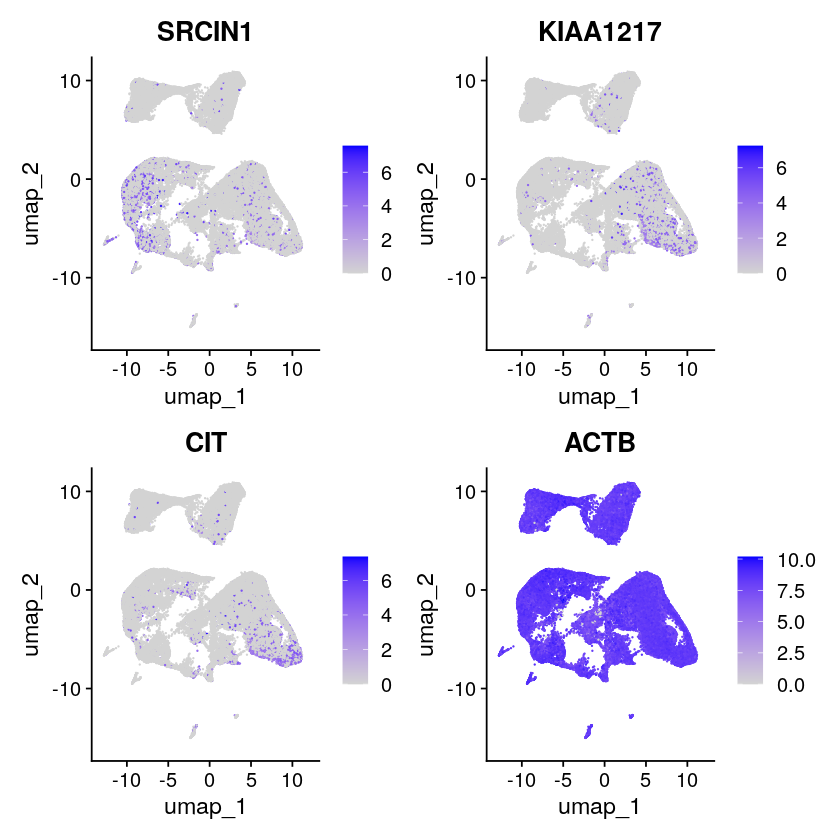

In [43]:
FeaturePlot(sc_data, c(genes_of_interest, "ACTB"))

In [46]:
ggsave("provv/a.png", plot = FeaturePlot(sc_data, c(genes_of_interest, "ACTB")),  width = 1920*2, height = 1980*2, units = "px")

In [47]:
# Get UMAP coordinates
umap <- Embeddings(sc_data, reduction = "umap")

# Get expression values for your genes
expr <- FetchData(sc_data, vars = c(genes_of_interest, housekeeping_genes[1]))

# Combine them into one data frame
expr$UMAP_1 <- umap[,1]
expr$UMAP_2 <- umap[,2]
head(expr)

,SRCIN1,KIAA1217,CIT,ACTB,UMAP_1,UMAP_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1_AAACCTGGTAGAGGAA_1_1m,0.000000,0,0,8.194983,-7.691025,9.630675
1_AAACCTGTCCTCAATT_1_1m,0.000000,0,0,7.805632,-7.269193,9.152771
1_AAACGGGGTTGAGGTG_1_1m,0.000000,0,0,7.864731,-8.274429,9.024467
1_AAAGTAGTCCACGCAG_1_1m,0.000000,0,0,8.503493,-7.074581,8.597800
1_AACACGTTCACCGTAA_1_1m,0.000000,0,0,8.462680,-6.661093,8.941132
1_AACCATGCACCAGGCT_1_1m,6.298202,0,0,9.069065,-6.332165,8.615707


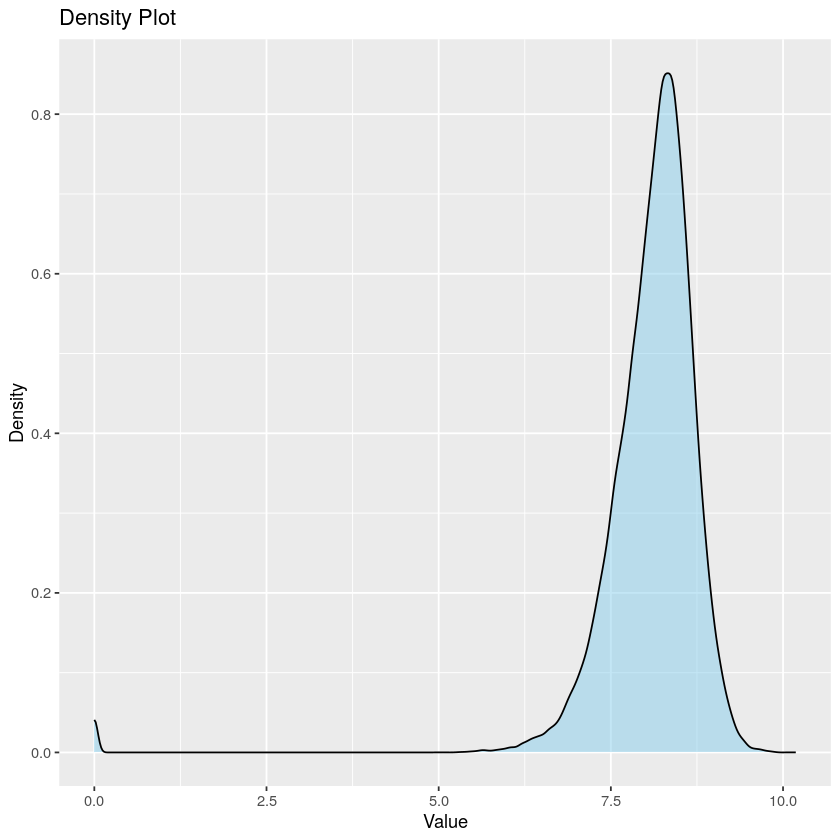

In [68]:
# Assume your_vector is your numeric vector
df <- data.frame(value = expr[, 4])

a <- ggplot(df, aes(x = value)) +
  geom_density(fill = "skyblue", alpha = 0.5) +
  labs(title = "Density Plot", x = "Value", y = "Density")

a

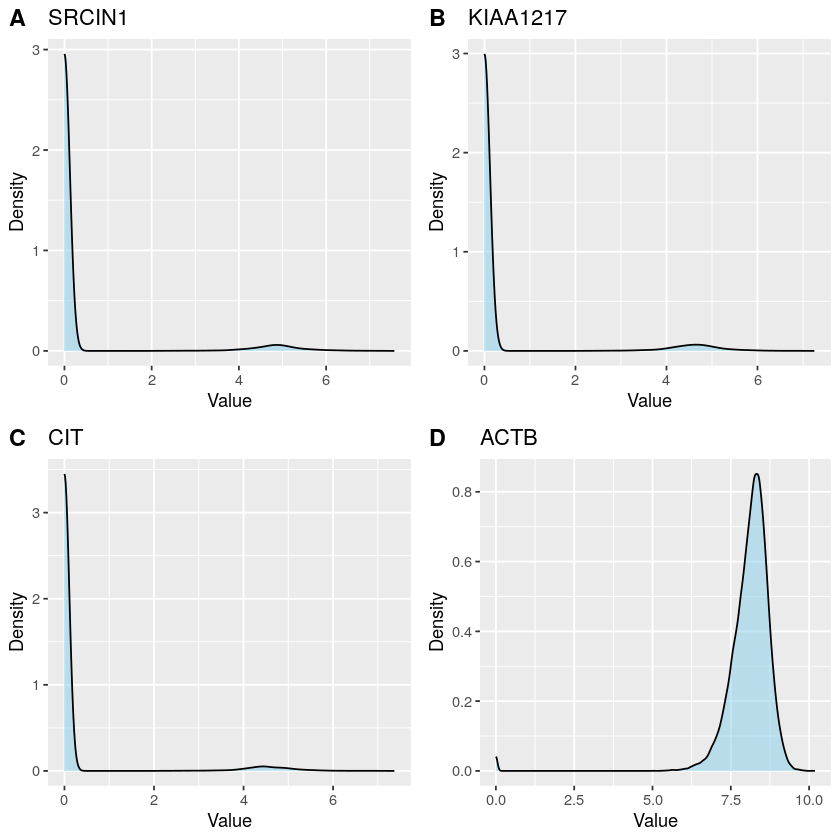

In [73]:
a <- list()
for (i in 1:4) {
    df <- data.frame(value = expr[, i])
    a[[i]] <- ggplot(df, aes(x = value)) +
      geom_density(fill = "skyblue", alpha = 0.5) +
      labs(title = colnames(expr[i]), x = "Value", y = "Density")
}
b <- do.call(plot_grid, c(a, labels = "AUTO", ncol = 2))
b

In [23]:
# Reshape for ggplot
library(tidyr)
expr_long <- pivot_longer(expr, all_of(genes_of_interest),
                          names_to = "gene", values_to = "expression")



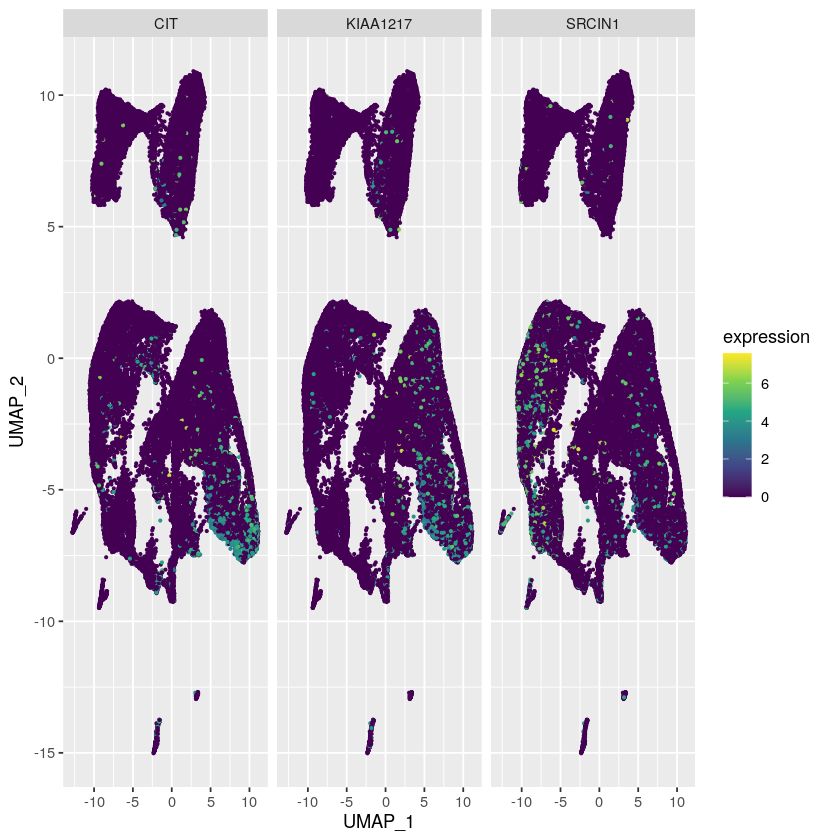

In [24]:

# Plot with shared scale
ggplot(expr_long, aes(UMAP_1, UMAP_2, color = expression)) +
  geom_point(size = 0.5) +
  scale_color_viridis_c() +
  facet_wrap(~gene)   # if you still want facets, but on the same scale

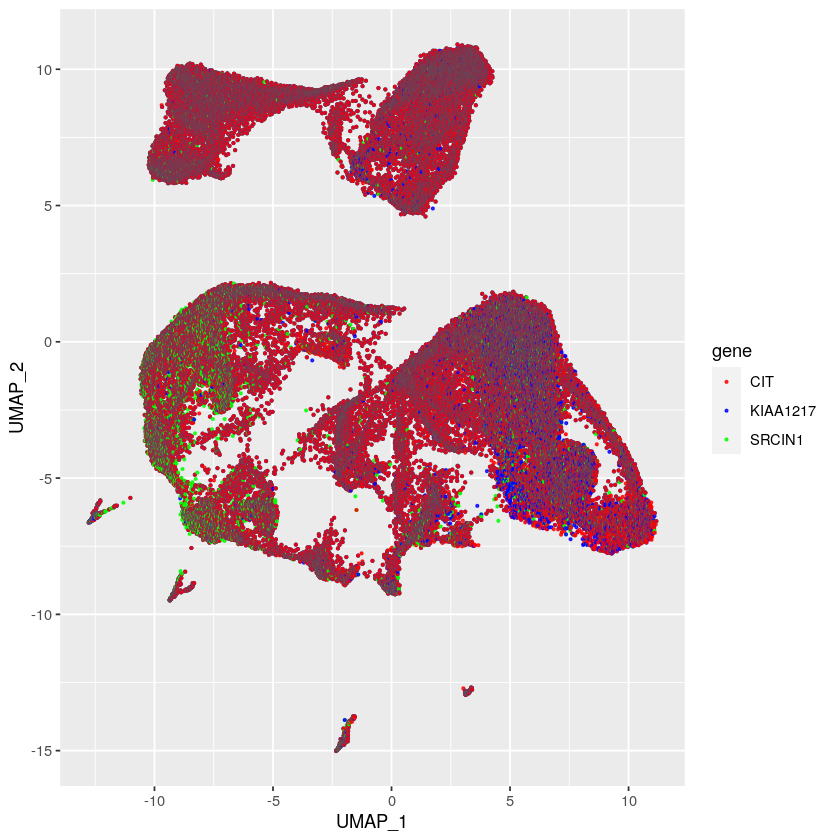

In [25]:
# Assign each cell to the gene with the max expression
expr_long2 <- expr_long %>%
  group_by(UMAP_1, UMAP_2) %>%
  slice_max(order_by = expression, n = 1)

ggplot(expr_long2, aes(UMAP_1, UMAP_2, color = gene)) +
  geom_point(size = 0.5, alpha = 0.8) +
  scale_color_manual(values = c("red", "blue", "green"))
